# How Convolution layer works?


- 기수: 13기

- 이름: 이채원

- 작성자: 13기 강승우

압축을 해제한 폴더 그대로 경로 변경 없이 문제를 푸시면됩니다.  
**CNN assignment폴더 아래에 data폴더, CNN 노트북파일, 이미지파일이 위치해야합니다.**  
문제가 생길 경우 경로 코드를 수정하시거나, 학술부에게 문의해주세요

이번 문제에서는 직접 Convolution 연산을 구현해보며 CNN의 동작 원리를 알아보고자 합니다.

**목표**
- `nn.Conv2d`와 동일한 연산을 **NumPy로 직접 구현**
- laplacian filter와 sobel filter를 **이미지에 적용**

**라이브러리 및 함수 정의**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from typing import Tuple, Optional

# 시각화 유틸
def show_gray(img, title=None):
    plt.figure(figsize=(4,4))
    plt.imshow(img, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

def minmax_norm(x: np.ndarray, eps: float = 1e-12):
    mn, mx = np.min(x), np.max(x)
    if mx - mn < eps:
        return np.zeros_like(x)
    return (x - mn) / (mx - mn)

**이미지 준비**

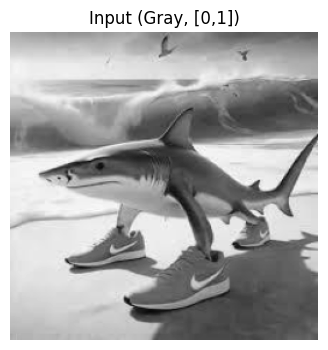

In [2]:
def load_image(path: Optional[str] = None, size: Tuple[int,int]=(256,256)) -> np.ndarray:
    img = Image.open(path).convert('L').resize(size, Image.BILINEAR)
    arr = np.array(img, dtype=np.float32) / 255.0
    return arr

# 사용 예시: path=None -> 합성 이미지
img = load_image(path="./tralla.jpg", size=(256,256))
show_gray(img, title='Input (Gray, [0,1])')


**Q1. numpy를 사용하여 이미지와 커널 배열을 입력으로 받는 conv2D_naive 함수를 구현하세요**

In [3]:
import numpy as np

def conv2d_naive(image: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    """
    Naive 2D convolution (padding=0, stride=1).
    
    Parameters
    ----------
    image : np.ndarray
        입력 이미지, shape (H, W)
    kernel : np.ndarray
        커널, shape (kH, kW)

    Returns
    -------
    out : np.ndarray
        convolution 결과, shape (H-kH+1, W-kW+1)
    """
    H, W = image.shape
    kH, kW = kernel.shape

    # 출력 크기 계산
    outH = H - kH + 1
    outW = W - kW + 1
    out = np.zeros((outH, outW))

    # 커널 뒤집기 (convolution 정의에 따라)
    kernel_flipped = np.flipud(np.fliplr(kernel))

    # 슬라이딩 윈도우로 convolution 수행
    for i in range(outH):
        for j in range(outW):
            region = image[i:i+kH, j:j+kW]
            out[i, j] = np.sum(region * kernel_flipped)

    return out


**Q2. 작성한 코드의 동작 방식이 왜 CNN의 convolution 연산과 동일한지 아래 마크다운에 자세히 설명해주세요. (예시를 들어 설명하셔도 좋습니다)**

conv2d_naive 함수와 CNN의 convolution 연산은 기본적으로 같은 방식으로 동작한다. 
입력 이미지의 패치를 커널과 원소별로 곱하고, 그 결과를 모두 더해 하나의 출력값을 만드는 슬라이딩 내적 연산이다. 
다만 convolution은 커널을 가로와 세로로 뒤집어서 적용하는 반면, 해당 함수에서는 커널을 뒤집지 않는 cross-correlation 방식을 사용한다. 
즉, 두 방식의 차이는 단순히 커널을 뒤집는지 여부에 있을 뿐이다 :)

**라플라시안 필터 적용 및 시각화**


- Laplace Filter  
\begin{bmatrix}
1 & 1 & 1\\
1 & -8 & 1\\
1 & 1 & 1
\end{bmatrix}

- Sobel Filter(수직)  
\begin{bmatrix}
-1 & 0 & 1\\
-2 & 0 & 2\\
-1 & 0 & 1
\end{bmatrix}

- Sobel Filter(수평)
\begin{bmatrix}
-1 & -2 & -1\\
0 & 0 & 0\\
1 & 2 & 1
\end{bmatrix}


In [4]:
laplace = np.array([[ 1, 1, 1],
                    [ 1,-8, 1],
                    [ 1, 1, 1]], dtype=np.float32)

sobel_vertical = np.array([[ -1, 0, 1],
                           [ -2, 0, 2],
                           [ -1, 0, 1]], dtype=np.float32)

sobel_horizontal = np.array([[ -1, -2, -1],
                             [  0,  0,  0],
                             [  1,  2,  2]], dtype=np.float32)

print('laplace:\n', laplace)
print('sobel_vertical\n', sobel_vertical)
print('sobel_horizontal:\n', sobel_horizontal)

laplace:
 [[ 1.  1.  1.]
 [ 1. -8.  1.]
 [ 1.  1.  1.]]
sobel_vertical
 [[-1.  0.  1.]
 [-2.  0.  2.]
 [-1.  0.  1.]]
sobel_horizontal:
 [[-1. -2. -1.]
 [ 0.  0.  0.]
 [ 1.  2.  2.]]


**구현한 Conv함수와 주어진 filter로 이미지의 edge를 검출해보세요**
- 결과의 범위가 음수가 될 수 있어, 시각화를 위해 정규화 사용

In [5]:
def apply_filter_and_visualize(img: np.ndarray, kernel: np.ndarray, stride: int = 1):

    resp = conv2d_naive(img, kernel)
    resp_signed = minmax_norm(resp)      # [-?, +?] -> [0,1] 정규화
    
    show_gray(img, 'Input')
    show_gray(resp_signed, 'Laplacian response (signed → min-max normalized)')
    return resp

=== Laplacian ===


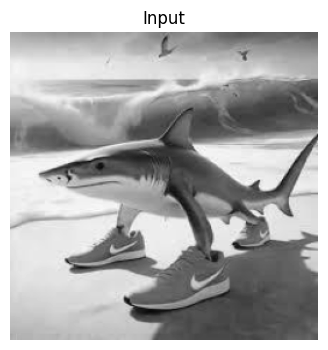

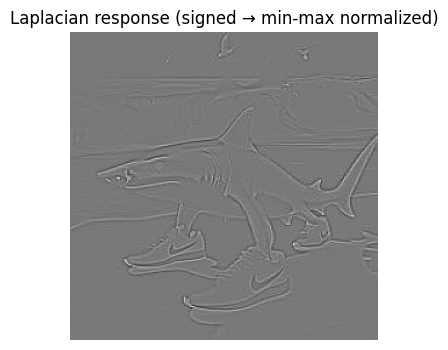

=== Sobel Vertical ===


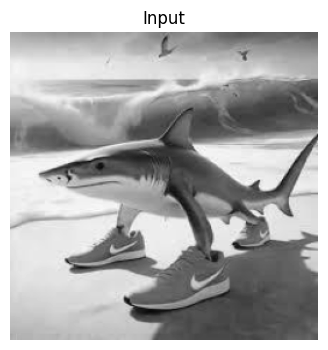

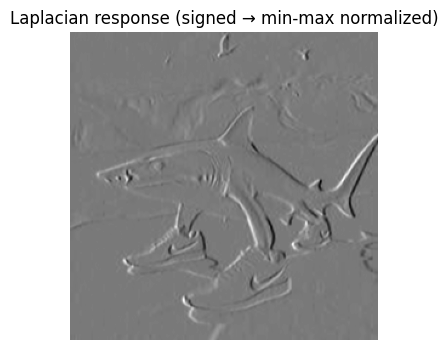

=== Sobel Horizontal ===


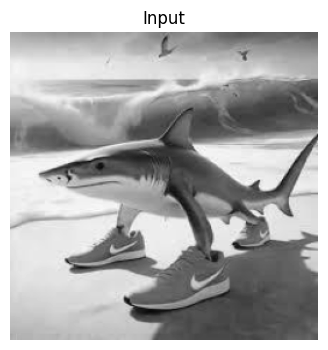

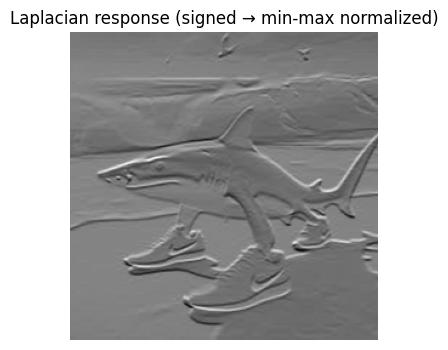

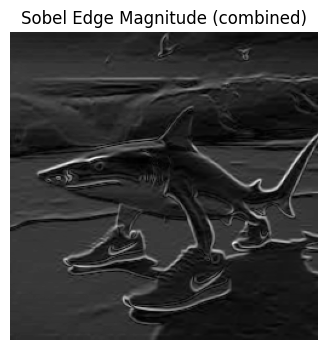

In [6]:
print('=== Laplacian ===')
resp_lp = apply_filter_and_visualize(img, laplace)

print('=== Sobel Vertical ===')
resp_sv = apply_filter_and_visualize(img, sobel_vertical)

print('=== Sobel Horizontal ===')
resp_sh = apply_filter_and_visualize(img, sobel_horizontal)

edge_mag = np.sqrt(resp_sv**2 + resp_sh**2)
edge_mag = minmax_norm(edge_mag)

show_gray(edge_mag, 'Sobel Edge Magnitude (combined)')

# Resnet18 구현하기

앞선 문제에서 Convolution 연산을 구현하여 보았으니,  
이번에는 **Resnet18을 직접 구현**해보고자 합니다.  
**Pytorch의 nn.Conv2d를 사용하시면 되지만**,  
본인이 구현한 Conv2d가 backward 연산이 가능하도록 설계되었다면 그것을 사용하여 구현하셔도 좋습니다.

**라이브러리 및 함수 정의**

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import torch.optim as optim
from tqdm import tqdm

data_path = "./data"

batch_size = 100

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainset = torchvision.datasets.CIFAR10(root=data_path, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=data_path, train=False, download=True, transform=transform) 
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:15<00:00, 10914759.46it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [8]:
def train(model, trainloader, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        model.parameters(),
        lr=0.01,
        weight_decay=5e-4,
        momentum=0.9
    )
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in tqdm(trainloader,desc=f'Epoch {epoch+1}/{epochs}'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(trainloader)}")

def test(model, testloader, device):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

**Q1. CIFAR10 데이터셋을 분류하는 Resnet18 classifier를 구현하세요**

Input (Batch size x 3 x 32 x 32) / Output (Batch size x Num class)  
이미지 배치를 입력받아 label 개수에 맞는 logit을 반환하도록 BasicBlock과 ResNet18 class를 정의해주세요.  
**ImageNet(224x224)을 입력으로 받는 Original ResNet18과 달리 CIFAR10(32x32)을 입력으로 받으므로,**  
- **conv1과 conv2 layer의 filter size와, maxpooling, stride,**  
- **fc layer의 output dimension을 적절히 변형하셔야 합니다.**
- **ResNet의 Architecture는 아래와 같습니다**

![사진](./ResNet_Architectures.png)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ---------- BasicBlock ----------
class BasicBlock(nn.Module):
    expansion = 1  # ResNet-18/34

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(planes)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(planes)
        self.downsample = downsample  # None or 1x1 conv-bn to match shape

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out


# ---------- ResNet18 for CIFAR-10 ----------
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # CIFAR: 32x32 → conv1을 3x3, s=1, pad=1 로 (maxpool 생략)
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(64)
        self.relu  = nn.ReLU(inplace=True)

        # 4개의 stage: [64, 128, 256, 512], 각 stage에 BasicBlock×2
        self.layer1 = self._make_layer(BasicBlock, 64,  blocks=2, stride=1)  # 32x32
        self.layer2 = self._make_layer(BasicBlock, 128, blocks=2, stride=2)  # 16x16
        self.layer3 = self._make_layer(BasicBlock, 256, blocks=2, stride=2)  # 8x8
        self.layer4 = self._make_layer(BasicBlock, 512, blocks=2, stride=2)  # 4x4

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc      = nn.Linear(512 * BasicBlock.expansion, num_classes)

        # Kaiming init (He et al.)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride):
        """blocks: 해당 stage의 블록 수(ResNet18은 2)"""
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = [block(self.in_planes, planes, stride, downsample)]
        self.in_planes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)   # 3x3, s=1
        x = self.bn1(x)
        x = self.relu(x)
        # (CIFAR는 maxpool 없음)

        x = self.layer1(x)  # 32x32
        x = self.layer2(x)  # 16x16
        x = self.layer3(x)  # 8x8
        x = self.layer4(x)  # 4x4

        x = self.avgpool(x)           # Bx512x1x1
        x = torch.flatten(x, 1)
        x = self.fc(x)                # Bx10
        return x

# 예시 사용
# model = ResNet18(num_classes=10)
# logits = model(torch.randn(8, 3, 32, 32))


모델이 안정적으로 학습되는지, 테스트 정확도가 잘 나오는지 (80% 이상) 확인해보세요

In [12]:
torch.manual_seed(42)
model = ResNet18().to(device)
train(model, trainloader, epochs=20)

Epoch 1/20: 100%|██████████| 500/500 [00:12<00:00, 40.76it/s]


Epoch 1/20, Loss: 1.4103919826745988


Epoch 2/20: 100%|██████████| 500/500 [00:11<00:00, 42.53it/s]


Epoch 2/20, Loss: 0.8836814917325974


Epoch 3/20: 100%|██████████| 500/500 [00:11<00:00, 42.16it/s]


Epoch 3/20, Loss: 0.6213724286556244


Epoch 4/20: 100%|██████████| 500/500 [00:11<00:00, 42.14it/s]


Epoch 4/20, Loss: 0.43257532474398613


Epoch 5/20: 100%|██████████| 500/500 [00:11<00:00, 42.06it/s]


Epoch 5/20, Loss: 0.2815305672287941


Epoch 6/20: 100%|██████████| 500/500 [00:11<00:00, 41.74it/s]


Epoch 6/20, Loss: 0.17914660988003014


Epoch 7/20: 100%|██████████| 500/500 [00:11<00:00, 41.98it/s]


Epoch 7/20, Loss: 0.13187624775990844


Epoch 8/20: 100%|██████████| 500/500 [00:11<00:00, 41.71it/s]


Epoch 8/20, Loss: 0.083576414745301


Epoch 9/20: 100%|██████████| 500/500 [00:12<00:00, 40.83it/s]


Epoch 9/20, Loss: 0.06729341343790293


Epoch 10/20: 100%|██████████| 500/500 [00:12<00:00, 41.34it/s]


Epoch 10/20, Loss: 0.06182836419250816


Epoch 11/20: 100%|██████████| 500/500 [00:11<00:00, 41.77it/s]


Epoch 11/20, Loss: 0.053665475049987435


Epoch 12/20: 100%|██████████| 500/500 [00:12<00:00, 41.66it/s]


Epoch 12/20, Loss: 0.05335815118439496


Epoch 13/20: 100%|██████████| 500/500 [00:12<00:00, 41.40it/s]


Epoch 13/20, Loss: 0.02951146241882816


Epoch 14/20: 100%|██████████| 500/500 [00:12<00:00, 41.38it/s]


Epoch 14/20, Loss: 0.0178719094437547


Epoch 15/20: 100%|██████████| 500/500 [00:12<00:00, 41.22it/s]


Epoch 15/20, Loss: 0.009528562180348673


Epoch 16/20: 100%|██████████| 500/500 [00:12<00:00, 41.57it/s]


Epoch 16/20, Loss: 0.002990489463787526


Epoch 17/20: 100%|██████████| 500/500 [00:12<00:00, 41.39it/s]


Epoch 17/20, Loss: 0.0011751817266922443


Epoch 18/20: 100%|██████████| 500/500 [00:12<00:00, 40.89it/s]


Epoch 18/20, Loss: 0.0008409510397468694


Epoch 19/20: 100%|██████████| 500/500 [00:11<00:00, 41.72it/s]


Epoch 19/20, Loss: 0.0008305103617021814


Epoch 20/20: 100%|██████████| 500/500 [00:12<00:00, 41.60it/s]

Epoch 20/20, Loss: 0.000816352786612697


In [13]:
test(model, testloader, device)

Test Accuracy: 82.85%


82.85

**Q2. Original ResNet18과 CIFAR10 분류용으로 구현한 ResNet18의 차이점과 그렇게 수정한 이유를 아래 마크다운에 자세히 설명해주세요.**

Original ResNet-18(ImageNet용)은 224×224 이미지를 전제로 7×7 conv(stride=2)와 maxpool로 초기에 해상도를 크게 줄이고, 마지막에 1000-way FC를 둔다. CIFAR-10은 입력이 32×32로 작기 때문에 초반에 이렇게 줄이면 정보 손실이 심하다. 따라서 CIFAR용 ResNet-18은 첫 conv를 3×3(stride=1)로 바꾸고 초기 maxpool을 제거해 공간 정보를 보존한다. 이후 stage에서 stride=2로 32→16→8→4로 차례로 줄이며, 블록 구조는 원본과 동일하다. 마지막 분류기는 데이터셋에 맞게 10-way FC로 교체하여 작은 입력에서도 안정적 학습과 높은 정확도를 낼 수 있게 했다..?